In [6]:
import pandas as pd
pd.set_option('display.max_rows', None)
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def create_metrics_comparison(results_path="../results"):
    """
    Create a comparison table for different models using all evaluation metrics.
    
    Parameters:
    -----------
    results_path : str
        Path to the results directory
        
    Returns:
    --------
    pd.DataFrame: Complete table with all metrics for each model combination
    """
    
    # Metric configuration
    metric_config = {
        'WAPE': {'format': '{:.1f}%'},
        'MAPE': {'format': '{:.1f}%'},
        'R²': {'format': '{:.3f}'},
        'MSE': {'format': '{:.1f}'},
        'RMSE': {'format': '{:.1f}'},
        'MAE': {'format': '{:.0f}'},
        
    }
    
    # Load results
    dfs = []
    for file_path in glob(os.path.join(results_path, "*average_results.csv")):
        df = pd.read_csv(file_path, index_col=0)
        df['Source_File'] = os.path.basename(file_path)
        dfs.append(df)

    all_models_results = pd.concat(dfs, ignore_index=True)

    # Mapping dictionaries with defined order
    model_names = {
        'LinearRegression': 'LR',
        'KNeighborsRegressor': 'KNN',
        'RandomForestRegressor': 'RF',
        'XGBRegressor': 'XGB',
        'CatBoostRegressor': 'CAT'
    }
    
    strategy_names = {
        'within_domain': 'Within Domain',
        'cross_domain': 'Cross Domain',
        'all_domain': 'All Domain'
    }

    target_names = {
        'Non-residential EUI (kWh/m2/year)': 'Non-residential',
        'Residential EUI (kWh/m2/year)': 'Residential'
    }

    # Apply mappings
    all_models_results['Strategy'] = all_models_results['Strategy'].map(strategy_names)
    all_models_results['Model'] = all_models_results['Model'].map(model_names)
    all_models_results['Target'] = all_models_results['Target'].map(target_names)

    # Set categorical order for models
    model_order = ['LR', 'KNN', 'RF', 'XGB', 'CAT']
    all_models_results['Model'] = pd.Categorical(
        all_models_results['Model'],
        categories=model_order,
        ordered=True
    )

    # Create full detailed table with ordered metrics
    metrics = ['MSE', 'MAE', 'WAPE' ,'RMSE','R²',  'MAPE']
    
    full_table = pd.pivot_table(
        all_models_results,
        index=['Model', 'Target'],
        columns=['Strategy'],
        values=metrics,
        aggfunc='mean'
    ).sort_index(level=0)  # Esto asegura que se mantenga el orden de los modelos

    # Format the values according to metric configuration
    formatted_table = full_table.copy()
    for metric in metrics:
        for strategy in strategy_names.values():
            col = (metric, strategy)
            formatted_table[col] = formatted_table[col].apply(
                lambda x: metric_config[metric]['format'].format(x)
            )
    
    return formatted_table

In [8]:
def create_model_comparison(comparison_table, metric, save_plot=True, save_path='figures/model_plots/model_comparison_mape.png'):
    """
    Create a comparison plot for different models using a specified metric.
    
    Parameters:
    -----------
    comparison_table : pd.DataFrame
        The formatted table from create_metrics_comparison function
    metric : str
        The metric to compare. Options: 'MAPE', 'R²', 'MSE', 'RMSE', 'MAE', 'WAPE'
    save_plot : bool
        Whether to save the plot to file
    save_path : str
        The path where the plot should be saved
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    """
    
    # Metric configuration with average labels
    metric_config = {
        'R²': {'format': '%.3f', 'label': 'Avg. R²', 'limits': (-1, 1)},
        'MSE': {'format': '%.0f', 'label': 'Avg. MSE', 'limits': (0, None)},
        'RMSE': {'format': '%.1f', 'label': 'Avg. RMSE', 'limits': (0, None)},
        'MAE': {'format': '%.1f', 'label': 'Avg. MAE', 'limits': (0, None)},
        'WAPE': {'format': '%.1f%%', 'label': 'Avg. WAPE (%)', 'limits': (0, 100)},
        'MAPE': {'format': '%.1f%%', 'label': 'Avg. MAPE (%)', 'limits': (0, 100)}
    }
    
    # Prepare data for plotting
    plot_data = comparison_table[metric].reset_index()
    plot_data = plot_data.melt(id_vars=['Model', 'Target'], 
                              var_name='Strategy', 
                              value_name=metric)
    
    # Convert string percentages to float for plotting
    if metric in ['MAPE', 'WAPE']:
        plot_data[metric] = plot_data[metric].str.rstrip('%').astype(float)
    else:
        plot_data[metric] = plot_data[metric].astype(float)

    # Color palette
    custom_palette = {
        'Non-residential': '#8ab2d5', 
        'Residential': '#98d095'
    }

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    strategies = ['Within Domain', 'Cross Domain', 'All Domain']

    # Calculate dynamic limits
    min_val = plot_data[metric].min()
    max_val = plot_data[metric].max()
    padding = (max_val - min_val) * 0.1
    
    # Set y-axis limits based on metric configuration
    base_min, base_max = metric_config[metric]['limits']
    y_min = base_min if base_min is not None else max(min_val - padding, 0)
    y_max = base_max if base_max is not None else max_val + padding

    for ax, strategy in zip(axes, strategies):
        strategy_data = plot_data[plot_data['Strategy'] == strategy]
        
        # Create bar plot
        bars = sns.barplot(
            data=strategy_data,
            x='Model',
            y=metric,
            hue='Target',
            palette=custom_palette,
            ax=ax
        )
        
        # Add value labels
        for container in bars.containers:
            bars.bar_label(container, 
                          fmt=metric_config[metric]['format'], 
                          padding=5, 
                          fontsize=14)
        
        # Customize appearance
        ax.set_title(f'{strategy}',
                    fontsize=16,
                    pad=20,
                    fontweight='bold')
        ax.set_ylabel(metric_config[metric]['label'], fontsize=14)
        ax.set_ylim(y_min, y_max)
        
        # Remove x-axis label
        ax.set_xlabel('')
        
        # Add baseline
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        
        # Adjust x-axis labels
        plt.setp(ax.get_xticklabels(), ha='right', fontsize=14)
        
        # Position legend with adjusted position and style
        if strategy == 'Cross Domain':
            legend = ax.legend(bbox_to_anchor=(0.5, -0.05),
                             loc='upper center',
                             ncol=2,
                             fontsize=16)
            # Remove bold from legend labels
            for text in legend.get_texts():
                text.set_fontweight('normal')
        else:
            ax.legend([],[], frameon=False)

    plt.tight_layout()

    # Save plot if requested
    if save_plot:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


In [9]:
comparison_table = create_metrics_comparison(results_path="../results")
comparison_table

MAE                                  MAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target                                                             
LR    Non-residential         40           56            30      21.0%   
      Residential             24           32            29      22.0%   
KNN   Non-residential         19           44            19       9.8%   
      Residential             19           31            20      15.1%   
RF    Non-residential         18           27            18       9.0%   
      Residential             18           27            18      14.1%   
XGB   Non-residential         25           27            19      11.2%   
      Residential             18           29            22      13.1%   
CAT   Non-residential         17           32            16       8.4%   
      Residential             16           26            15      12.3%   

                                                        MSE               \
Strategy              Cross Domain Within Domain All Domain Cross Domain   
Model Target                                                               
LR    Non-residential        32.7%         16.8%     3384.3       5533.7   
      Residential            35.6%         24.6%     1055.1       1599.7   
KNN   Non-residential        23.7%          9.7%     1271.1       4053.6   
      Residential            26.4%         15.5%     1015.1       1652.4   
RF    Non-residential        13.4%          8.9%     1182.8       2313.9   
      Residential            23.8%         13.3%      956.3       1602.4   
XGB   Non-residential        13.9%          9.2%     2354.4       2414.0   
      Residential            23.7%         15.3%     1030.9       1704.2   
CAT   Non-residential        16.4%          8.0%     1323.3       2908.1   
      Residential            21.4%         11.3%      751.8       1353.8   

                                          RMSE                             \
Strategy              Within Domain All Domain Cross Domain Within Domain   
Model Target                                                                
LR    Non-residential        2567.5       47.5         65.7          40.3   
      Residential            2275.3       30.1         39.7          38.4   
KNN   Non-residential        1387.5       30.5         56.7          30.6   
      Residential            1022.8       26.7         38.4          27.3   
RF    Non-residential        1236.4       28.1         39.1          28.4   
      Residential            1002.8       25.4         34.2          25.9   
XGB   Non-residential        1301.0       36.2         41.1          28.8   
      Residential            1528.0       25.0         35.6          33.3   
CAT   Non-residential        1079.0       29.1         46.0          26.1   
      Residential             691.4       22.6         31.6          22.1   

                              R²                                  WAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target                                                             
LR    Non-residential     -2.092      -11.403        -0.263      20.1%   
      Residential         -0.304       -3.176        -0.259      20.0%   
KNN   Non-residential      0.142      -10.304         0.101       9.3%   
      Residential          0.377       -1.350         0.350      14.4%   
RF    Non-residential      0.283       -0.260         0.196       8.9%   
      Residential          0.420       -0.419         0.469      13.3%   
XGB   Non-residential     -0.062       -0.520         0.065      11.3%   
      Residential          0.481       -0.319        -0.156      12.8%   
CAT   Non-residential      0.267       -1.366         0.379       8.4%   
      Residential          0.558        0.025         0.584      12.2%   

                                                  
Strategy              Cross Domain Within Domain  
Model Targ

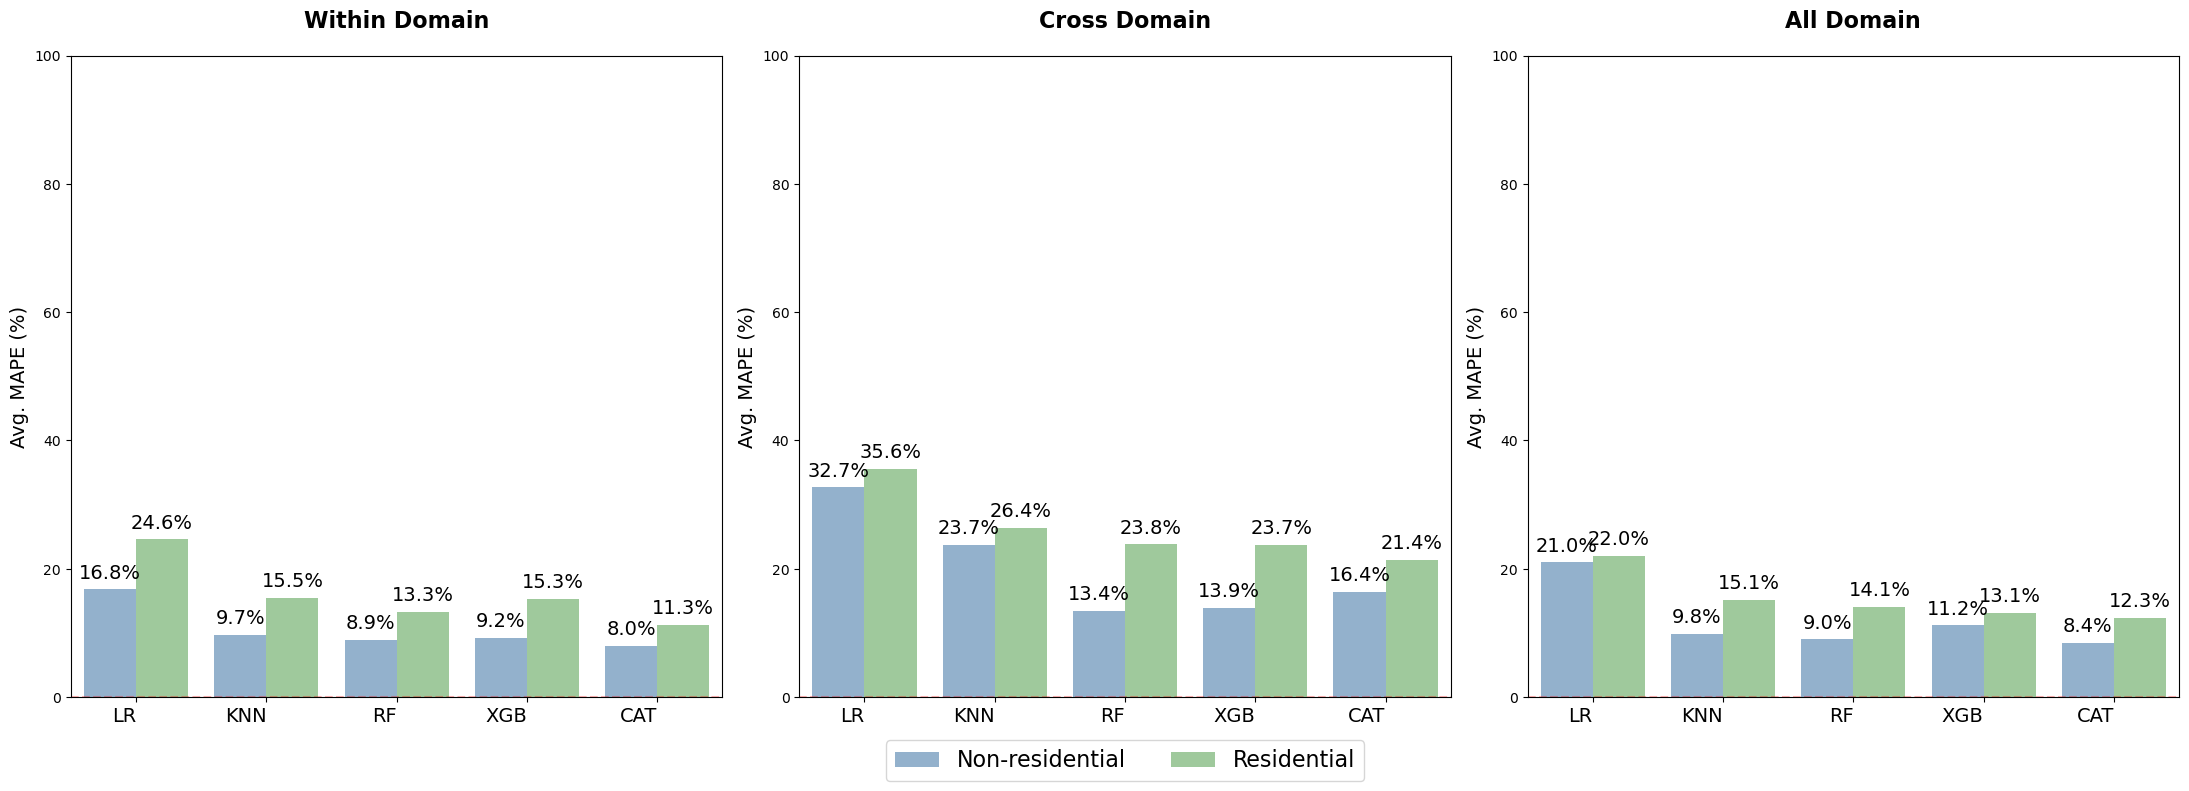

In [10]:
fig = create_model_comparison(comparison_table, metric='MAPE', save_path='../figures/model_plots/00_model_comparison_mape.png')
plt.show()


In [11]:
comparison_table.to_csv("../results/comparison_average_results.csv")